<a href="https://colab.research.google.com/github/DanielDialektico/Machine-Learning/blob/main/Regresi%C3%B3n%20Lineal/Regresi%C3%B3n_Lineal_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

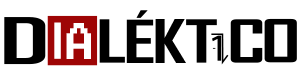

**INTRODUCCIÓN A LA REGRESIÓN LINEAL 📊**

# 1. Introducción

En este ejercicio aplicarás el método de **regresión lineal** para ajustar una **recta** a un **conjunto de datos** y realizar **predicciones** sobre los valores de una variable respecto a otra; esto permitirá demostrar la sencillez y poder de la aplicación de uno de los **algoritmos** básicos del **machine learning** a un conjunto de datos reales.

En este caso, volveremos a remitirnos a otro cúmulo de información sobre automóviles, esta vez de uno que consiste en especificaciones y precios de 84 carros del año 2022 vendidos en la India. 

Los detalles del conjunto de datos pueden ser consultados en el **apéndice** al final.

# 2. Objetivo

Se plantea el siguiente caso: supóngase que estamos haciendo un estudio mercadológico, y deseamos saber cómo se han comportado las variaciones de los **precios** de automóviles respecto a su **potencia de frenado**, la cual va desde los 10 hasta los 739 BPH (break power horse: caballo de fuerza de frenado), y para lo que se nos ha proporcionado una tabla con datos.

Las preguntas a responder son las siguientes:

1.   ¿Cómo tiende a comportarse el **precio** de los automóviles respecto a la **potencia de frenado**?
2.   De acuerdo con la tendencia, ¿cuál es el precio aproximado, en dólares estadounidenses, de un automóvil con una capacidad de 160 BPH?


# 3. Carga y exploración de datos

Para responder a las cuestiones planteadas, antes deberemos revisar cómo es la información que se nos ha proporcionado, y cuáles **adecuaciones** debemos hacer para su correcto **procesamiento**.

Antes que nada, cargaremos las demás librerías a utilizar, e instalaremos una librería que nos ayudará en las etapas de preprocesamiento, cuya intervención se explicará más adelante:

In [ ]:
#Se instala la librería alibi-detect
!pip install alibi-detect

#Se importan las librerías.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from datetime import date
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#Se filtran las advertencias.
warnings.filterwarnings('ignore')
#Se define el estilo de las gráficas.
plt.style.use('seaborn-v0_8-whitegrid')

Una vez hecho esto, proseguimos a cargar el **conjunto de datos** y leerlo como una tabla (dataFrame) de **[Pandas](https://pandas.pydata.org/)**. 

Imprimiremos la tabla para tener una primera visión de los datos que disponemos:

In [ ]:
#Se carga el conjunto de datos desde un repositorio de GitHub.
dataset = pd.read_csv('https://raw.githubusercontent.com/DanielDialektico/Machine-Learning/main/Conjuntos%20de%20datos/Autom%C3%B3viles_Cardekho.csv')

#Se imprime el conjunto de datos.
dataset

A primera vista, se puede observar que se trata una tabla con **84 renglones** (ejemplos de entrenamiento) y **15 columnas**, las cuales representan los atributos de los automóviles.

Para obtener mayor información sobre estos atributos, imprimiremos datos estadísticos sobre ellos:

In [ ]:
#Se imprime una tabla con datos estadísticos de cada variable del conjuto de datos.
dataset.describe()

En esta tabla, la cual fue explicada en la [introducción al preprocesamiento de datos](https://colab.research.google.com/github/DanielDialektico/Machine-Learning/blob/main/Preprocesamiento/Preprocesamiento_intro.ipynb), nos podemos percatar de algunas **propiedades** del conjunto de datos. Por ejemplo, en lo que respecta a las variables que vamos a utilizar, podemos observar una **desviación estándar** relativamente alta para la **potencia de frenado**, lo cual puede indicar presencia de **valores atípicos**. 

Por último, imprimimos la información general de cada columna, buscando posibles datos no nulos e incongruencias en sus tipos:

In [ ]:
dataset.info()

Con esto constatamos la ausencia de datos inválidos, así como de la adecuada definción de cada tipo (Dtype) para cada variable (el **precio** y la **potencia** están declarados como tipo numérico).

# 4. Preprocesamiento de datos

Una vez realizada la breve **exploración** de los datos, procedemos a ejecutar las etapas de **preprocesamiento**, que serán las siguientes:



*   **Limpieza de datos**: se delimitarán los atributos solo a las columnas necesarias, y se removerán valores atípicos (outliers). 
*   **Transformación de datos**: se transformarán los precios de rupias a dólares.
*  **Reducción de datos**: se delimitará el conjunto de datos solo a los atributos de interés eliminando las columnas sobrantes.



## 4.1 Transformación, reducción y limpieza 

Dada la simplicidad de todas las actividades, salvo la **remoción de valores atípicos** (la cual requerirá algo de **procesamiento** de datos), realizaremos primero todas las adecuaciones de las etapas de preprocesamiento, y dejaremos esta hasta el final.

En el siguiente bloque, se reduce el conjunto de datos a las 2 columnas que se utilizarán, y se cambian los nombres de las variables para su mejor comprensión:

In [ ]:
#Se seleccionan solo las columbas de precio y potencia para el análisis propuesto.
dataset = dataset[['price','max_power_bhp']]

#Se traduce el nombre de las variables.
dataset.columns = ['Precio', 'Poder_máximo_BHP']

#Se imprime la tabla resultante.
dataset

Ahora, cambiamos el valor de los precios convirtiéndolos a dólares con una simple multiplicación por un escalar:

In [ ]:
#Se multiplican los precios de la columna por un factor para la conversión en dólares.
dataset['Precio'] = dataset['Precio']*0.012

#Se imprime la tabla resultante.
dataset

Se puede notar cómo los valores se han modificado correctamente. Con esto, podemos continuar con el último paso definido del preprocesamiento de datos.

## 4.2 Detección y remoción de valores atípicos

Para identificar y eliminar los valores que se **desvían** considerablemente del **comportamiento** **típico** de los datos, utilizaremos la librería antes instalada: [**alibi-detect**](https://github.com/SeldonIO/alibi-detect), la cual ofrece 10 **algoritmos** diferentes para la detección de este tipo de **observaciones**. 

En este caso, se utilizará el algoritmo **Isolation Forest**, el cual detecta **anormalidades** en los datos utilizando árboles binarios.

Los detalles sobre el funcionamiento de este se escapan de la cobertura de esta práctica, pero pueden ser consultados en [**Liu et al. (2008)**](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf).

Antes de aplica el algoritmo, con la intención de atisbar posibles **valores atípicos**, mostraremos la gráfica de los puntos generados por ambas variables, donde la variable **dependiente** es el **precio**, y la variable **independiente** el **poder máximo de frenado**.

In [ ]:
#Se definen cuáles son las entradas y salidas del conjunto de datos.
inputs = dataset['Poder_máximo_BHP']
outputs = dataset['Precio']

#Se genera la gráfica de dispersión de ambas variables.
plt.figure(figsize=(9, 9))
plt.plot(inputs, outputs, 'o', markersize = 7)
plt.title("PRECIO RESPECTO A PODER MÁXIMO DE FRENADO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 16}, pad = 15)
plt.suptitle("Fig. 1 Representación en el plano del conjunto de datos.", fontproperties = {'family': 'DejaVu Sans', 'size': 16}, y=-0.001)
plt.xlabel("POTENCIA MÁXIMA DE FRENADO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad=15)
plt.ylabel("PRECIO (USD)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad=15)
plt.show()

Podemos notar algunos **ejemplos de entrenamiento** (puntos) posicionados en regiones **lejanas** a la agrupación de la mayoría. 

Para su detección, procedemos a utilizar el algoritmo **[Isolation Forest](https://docs.seldon.io/projects/alibi-detect/en/stable/od/methods/iforest.html)** con la librería alibi_detect. 

Para visualizar el resultado, resaltaremos los puntos identificados como valores atípicos con un color rojo:

In [ ]:
#Se importa el algoritmo desde alibi_detect.
from alibi_detect.od import IForest

#Se define el método con sus respectivos parámetros.
od = IForest(threshold=0., n_estimators=400)

#Se ejecuta el algoritmo sobre el conjunto de datos.
od.fit(dataset[['Poder_máximo_BHP', 'Precio']])
preds = od.predict(dataset[['Poder_máximo_BHP', 'Precio']], return_instance_score=True)

#Se añade una columna donde se asocia cada ejemplo de entrenamiento a un valor n = 0 si es un valor atípico, n = 1 en el caso contrario.  
dataset['Valores_atípicos'] = preds['data']['is_outlier']

#Se generan dos subconjuntos de datos, uno filtrado, y otro que solo contiene valores atípicos.
outliers = dataset.loc[(dataset['Valores_atípicos']==1)]
dataset = dataset.loc[(dataset['Valores_atípicos']==0)]

#Se definen los puntos a graficar, y se imprimen.
inputs = dataset['Poder_máximo_BHP']
outputs = dataset['Precio']

x_outliers = outliers['Poder_máximo_BHP']
y_outliers = outliers['Precio']

plt.figure(figsize=(9, 9))
plt.plot(inputs, outputs, 'o', markersize = 7)
plt.plot(x_outliers, y_outliers, 'o', color = 'red', label = 'Valores atípicos', markersize = 7)
plt.title("PRECIO RESPECTO A PODER MÁXIMO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 16}, pad = 15)
plt.suptitle("Fig. 2 Visualización de los datos atípicos (puntos color rojo) en el conjunto de datos.", fontproperties = {'family': 'DejaVu Sans', 'size': 16}, y=-0.001)
plt.xlabel("POTENCIA MÁXIMA DE FRENADO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.ylabel("PRECIO (USD)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.legend(loc='upper left', prop = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 14}, frameon = True, framealpha = 1, facecolor  = '#dddddd', shadow = True)
plt.show()

En la **figura 2** se aprecia la diferenciación con coloración en rojo de los puntos señalados como **outliers**. Filtremos estos valores y graficaremos las observaciones restantes, las cuales representan el conjunto de datos finalmente preprocesado:

In [ ]:
#Se grafica el conjunto de datos preprocesado.
plt.figure(figsize=(9, 9))
plt.plot(inputs, outputs, 'o', markersize = 7)
plt.title("PRECIO RESPECTO A PODER MÁXIMO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 16}, pad = 15)
plt.suptitle("Fig. 3 Conjunto de datos preprocesado.", fontproperties = {'family': 'DejaVu Sans','size': 16}, y=-0.001)
plt.xlabel("POTENCIA MÁXIMA DE FRENADO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.ylabel("PRECIO (USD)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.show()

# 5. Regresión lineal simple

Para dar solución a las preguntas planteadas en los objetivos, utilizaremos el método de **regresión lineal simple** incovando a la clase definida en la librería [**scikit-learn**](https://scikit-learn.org/stable/index.html), la cual nos permitirá utilizar el método de **mínimos cuadrados** para la obtención de la **ecuación de la recta**.

En el siguiente bloque se definen los conjuntos de datos de **entrenamient**o y **prueba**, los cuales tendrán una proporción de **80%** y **20%** del total de ejemplos de entrenamiento, y se entrena el modelo de regresión lineal:

In [ ]:
#Se generan los conjuntos de entrenamiento y prueba para las entradas (x) y salidas (y), con una proporción 80-20.
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1,1)
y_train = y_train.to_numpy().reshape(-1,1)

#Se define la regresión lineal.
regr = linear_model.LinearRegression()

# Se entrena el modelo sobre los conjuntos de entrenamiento, utilizando el método de mínimos cuadrados.
regr.fit(x_train, y_train);

Una vez ajustados los datos con el método **fit()**, podemos graficar la línea recta resultante:

In [ ]:
#Se grafica la línea recta obtenida.
plt.figure(figsize=(9, 9))
plt.plot(inputs, outputs, 'o', markersize = 7)
plt.plot(inputs, regr.predict(inputs.to_numpy().reshape(-1,1)), color="#9E0505", linewidth=5, label='Recta de regresión')
plt.title("PRECIO RESPECTO A PODER MÁXIMO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 16}, pad = 15)
plt.xlabel("POTENCIA MÁXIMA DE FRENADO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.ylabel("PRECIO (USD)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.suptitle("Fig. 4 Visualización del conjunto de datos y la recta ajustada generada por la ecuación resultante de la regresión lineal.", fontproperties = {'family': 'DejaVu Sans', 'size': 16}, y=-0.001)
plt.legend(loc='upper left', prop = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 14}, frameon = True, framealpha = 1, facecolor  = '#dddddd', shadow = True)
plt.show()

Con esta primera ilustración podemos resolver la **primera interrogante**: *¿cómo se comporta el precio de los automóviles respecto a la potencia de frenado?* 

En la **figura 4** podemos ver cómo a valores más altos de la **potencia máxima** se obtienen también cantidades más altas del **precio**, razón por la cual la **pendiente** de la recta es **positiva**. Esto nos indica que el precio es directamente proporcional a la potencia: uno aumenta conforme el otro también, y por lo tanto la **tendencia** entre ambos es **creciente**.


## 5.1 Realizando predicciones con el modelo

Para responder a la **segunda pregunta**, debemos recordar cómo se utiliza el modelo obtenido por la regresión lineal para hacer **predicciones**. Recordemos que la ecuación de la recta dada por este método tiene la siguiente forma:


\begin{align}
        h(x)=\theta_{0}+\theta_{1}x\quad(1.1) 
    \end{align}

donde $\theta_{0}$ es el **parámetro** que determina la **intersección** con el eje $y$, y $\theta_{1}$ el **parámetro** que define su **pendiente**.

Para poder consultar los valores de estos **parámetros** después de hacer la regresión, utilizaremos los atributos **coef_** y **rank_** del modelo definido, los cuales nos entregarán los valores de los **coeficientes de regresión** correspondientes a la intersección y la pendiente, respectivamente:

In [ ]:
#Se obtienen los valores de los coeficientes de regresión calculados.
theta_0 = regr.intercept_[0]
theta_1 = regr.coef_[0][0]

print('El valor de los parámetros de regresión de la ecuación de la recta son:\ntheta_0 = ' + str(theta_0)[0:8] + '\ntheta_1 = ' + str(theta_1)[0:6])

Por lo tanto, la ecuación quedaría de la siguiente forma:

In [ ]:
#Se imprime la ecuación resultante:
print('h(x) = ' + str(theta_0)[0:8] + ' + ' + str(theta_1)[0:6] + 'x')

Ahora, para responder a la pregunta: ¿cuál es el precio aproximado, en dólares estadounidenses, de un automóvil de 160 BPH?, utilizaremos esta ecuación sustituyendo el valor de $x$ por el de 160, lo cual se puede hacer utilizando el método **predict()**:


In [ ]:
#Se define el valor de x para la predicción.
input_pred = 160
print('El precio de un automóvil dada una potencia de 160 BHP es: $' + str(regr.predict(np.array([[input_pred,]]))[0][0])[0:2] + ',' + 
         str(regr.predict(np.array([[input_pred,]]))[0][0])[2:8] + ' USD')

Es decir, para un valor de potencia de 160 bhp, el valor impreso arriba es el **precio estimado**. 

Para ilustrar esto, veamos en dónde se encuentra el **punto predicho** por el **modelo** en nuestra recta respecto al conjunto de datos:

In [ ]:
#Se grafica el resultado.
plt.figure(figsize=(9, 9))
plt.plot(inputs, outputs, 'o', markersize = 7)
plt.plot(inputs, regr.predict(inputs.to_numpy().reshape(-1,1)), color="#9E0505", linewidth=5, label='h(x) = ' + str(theta_0)[0:8] + ' + ' + str(theta_1)[0:6] + 'x' )
plt.plot(input_pred, regr.predict(np.array([[input_pred,]])), 'o', markersize = 17, color="orange", label = 'Predicción = $' + str(regr.predict(np.array([[input_pred,]]))[0][0])[0:2] + ',' + 
         str(regr.predict(np.array([[input_pred,]]))[0][0])[2:8] + ' USD');
plt.title("PRECIO RESPECTO A PODER MÁXIMO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 16}, pad = 15)
plt.xlabel("POTENCIA MÁXIMA DE FRENADO (BHP)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.ylabel("PRECIO (USD)", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12}, labelpad = 15)
plt.suptitle("Fig. 5 Línea de regresión y el punto calculado por el modelo sobre esta (punto amarillo).", fontproperties = {'family': 'DejaVu Sans', 'size': 16}, y=-0.001)
plt.legend(loc='upper left', prop = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 14}, frameon = True, framealpha = 1, facecolor  = '#dddddd', shadow = True)
plt.show()

## 5.2 Evaluando su precisión

Uno de las etapas clave de todo modelo de **machine learning**, consiste en la **evaluación** de su **precisión** en la ejecución de sus tareas. 

Para esto, se utilizan diversas **funciones** que permiten calcular los **errores** respecto a los valores reales del conjunto de datos (conjunto de prueba).

Esto lo veremos de forma más detallado en un futuro, por el momento, utilizaremos dos métricas: el **error cuadrático medio** (MSE), el cual fue definido en nuestra exploración, y el **coeficiente de determinación $R^{2}$**, el cual conforme se aproxima a $1$, indica mayor **rendimiento** de **predicción** del modelo (dicho de forma simplificada).

In [ ]:
y_pred = regr.predict(x_test.to_numpy().reshape(-1,1))
print("Error cuadrático medio: %.2f" % mean_squared_error(y_test, y_pred))
print("Coeficiente de determinación: %.2f" % r2_score(y_test, y_pred))

Como verás, el coeficiente de determinación tiene una aproximación a 1 considerable, más no del 100% , esto nos plantea la incógnita de cómo podemos generar un modelo con mayor capacidad predictiva. 

En lo sucesivo, estaremos explorando más **algoritmos** que nos abrirán un amplio abanico de posibilidades para el entrenamiento de modelos de **aprendizaje supervisado**.

#Ejercicio

Hasta aquí concluimos con esta práctica, pero aún puedes poner a prueba tus conocimientos haciendo unas cuantas **modificaciones** a las siguientes celdas de código. A continuación, se cargará el **conjunto de datos** de **calificaciones** y **horas de estudio** visto en la introducción a la regresión lineal (esta celda no requiere modificación alguna): 

In [ ]:
#Se visualiza el conjunto de datos:
dataset = pd.read_csv('https://raw.githubusercontent.com/DanielDialektico/Machine-Learning/main/Regresi%C3%B3n%20Lineal/Estudiantes_puntaje.csv', encoding='latin-1')
dataset

Para aplicar regresión lineal y realizar predicciones sobre este conjunto de datos solo deberás añadir algunos elementos a los siguientes bloques de código:

Define las **entradas** y **salidas** del conjunto de datos, colocando entre comillas el nombre de las variables.

Recuerda cuáles son tus entradas y salidas, y que:

Inputs = entradas

Outputs = salidas

In [ ]:
inputs = dataset[#-Nombre de la columna de entradas]
outputs = dataset[#-Nombre de la columna de salidas]

Por último, en el siguiente código se aplica la regresión lineal simple para el **entrenamiento** del modelo. Aquí solo deberás especificar con qué valores deseas realizar una predicción con la ecuación resultante; se recomienda utilizar un **número continuo** de entre **0** y **10**.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1,1)
y_train = y_train.to_numpy().reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train);
theta_0 = regr.intercept_[0]
theta_1 = regr.coef_[0][0]

#Edita esta línea de código
input_pred = #Valor para el que deseas probar el modelo.

plt.figure(figsize=(9, 9))
plt.plot(inputs, outputs, 'o', markersize = 7)
plt.plot(inputs, regr.predict(inputs.to_numpy().reshape(-1,1)), color="#9E0505", linewidth=5, label='h(x) = ' + str(theta_0)[0:4] + ' + ' + str(theta_1)[0:4] + 'x' )
plt.plot(input_pred, regr.predict(np.array([[input_pred,]])), 'o', markersize = 17, color="orange", label = 'Predicción = ' + str(regr.predict(np.array([[input_pred,]]))[0][0])[0:5],);
plt.title("PUNTAJE RESPECTO A HORAS DE ESTUDIO", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 16})
plt.xlabel("HORAS DE ESTUDIO", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12})
plt.ylabel("PUNTAJE", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 12})
plt.suptitle("Fig. 6 Linea de regresión y el punto calculado por el modelo sobre esta (punto amarillo).", fontproperties = {'family': 'DejaVu Sans', 'size': 16}, y=-0.001)
plt.legend(loc='upper left', prop = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 14}, frameon = True, framealpha = 1, facecolor  = '#dddddd', shadow = True)
plt.show()

En la **figura 6** podrás observar la ecuación resultante, la recta generada a partir de esta, y la **predicción** realizada por el **modelo**.

▶ [Regresar a la lección](https://dialektico.com/introduccion-a-la-regresion-lineal/) 🧙

# 7. Apéndice

## 7.1 Conjunto de datos

El conjunto de datos utilizado para este ejercicio es un subconjunto de un conjunto de datos de segunda mano extráidos de https://www.cardekho.com/, y ofrecidos de forma gratuita en [Kaggle](https://www.kaggle.com/). 

Consiste en un total de 84 automóviles en venta en la India durante el 2022, con 16 atributos asociados:

*   **car_name:** nombre del coche.
*   **reviews_count:** número de opiniones dadas al coche en el sitio web.
*   **fuel_type:** tipo de combustible que utiliza el coche. Los valores posibles son petróleo, diesel y eléctrico.
*   **engine_displacement:** medida del volumen del cilindro barrido por todos los pistones de un motor de pistones, excluyendo las cámaras de combustión. La unidad es (cc).
*   **no_cylinder:** número de cilindros que contiene el coche. Es $0$ en caso de vehículos eléctricos.
*   **seating_capacity:** número de personas que caben en el coche.
*   **transmission_type:** tipo de transmisión, los valores posibles son manual, automático y eléctrico.
*   **fuel_tank_capacity:** capacidad máxima del depósito de combustible del coche. 0 en caso de vehículo eléctrico.
*   **body_type**: forma de la carrocería del coche.
*   **rating_Integer:** clasificación proporcionada al coche en el sitio web. Valores entre 0 y 5.
*   **starting_price:** precio inicial del coche en Rs.
*   **ending_price:** precio final del coche en Rs.
*   **max_torque_nm:** Torque máximo que puede proporcionar el coche
*   **max_torque_rpm:** RPM al que se puede alcanzar el torque máximo.
*   **max_power_bhp:** Potencia de frenado máxima del coche
*   **max_power_rp:** RPM al que se puede alcanzar la potencia máxima.
